In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import scipy as sp
import warnings
import matplotlib.pyplot as plt
from theano import tensor as tt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

az.style.use('arviz-darkgrid')
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Medium

## 13M1
Taken from PyMC3 dev's Chp_13 notebook:

In [38]:
np.repeat(np.arange(N_cafes), N_visits) +1

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20])

In [39]:
a = 3.5        
b = -1.        
sigma_a = 1.   
sigma_b = 0.5  
rho = 0

Mu = [a, b]
cov_ab = sigma_a * sigma_b * rho
Sigma = np.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]]) #Sigma covariance matrix

# simulate observations
N_cafes = 20
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

N_visits = 10
afternoon = np.tile([0,1], N_visits * N_cafes//2)
cafe_id = np.repeat(np.arange(N_cafes), N_visits)

mu = a_cafe[cafe_id] + b_cafe[cafe_id]*afternoon
sigma = 0.5 # std dev within cafes
wait = np.random.normal(loc=mu, scale=sigma, size=N_visits*N_cafes)

# Create dataframe
d = pd.DataFrame(dict(cafe=cafe_id , afternoon=afternoon , wait=wait))
d.head(11)

cafe  afternoon      wait
0      0          0  2.836140
1      0          1  2.236865
2      0          0  2.340981
3      0          1  2.788423
4      0          0  2.533329
5      0          1  2.588111
6      0          0  4.232449
7      0          1  1.389327
8      0          0  2.798222
9      0          1  2.187705
10     1          0  4.310185

In [40]:
with pm.Model() as m13_m1:
    # First start with specifying priors and structure of co-variance matrix
    # Paramertising with cholesky cov matrix
    std_ab = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', n=2, eta=2, sd_dist=std_ab)
    
    # Compute covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower = True)
    cov = pm.math.dot(chol, chol.T)
    
    # Use deterministic functions to generate quantities for the std and corr parameters
    sigma_ab = pm.Deterministic('sigma_cafe', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    rho = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    # Priors for grand mean
    a = pm.Normal('a', mu=0, sd=10)
    b = pm.Normal('b', mu=0, sd=10)
    
    # Population of varying effects. Getting alpha and beta for each cafe
    ab_cafe = pm.MvNormal('ab_cafe', mu=tt.stack([a, b]), chol = chol, shape = (N_cafes, 2))
    
    mu = ab_cafe[:, 0][cafe_id] + ab_cafe[:, 1][cafe_id] * afternoon
    sd = pm.HalfCauchy('sigma',  beta=2)
    
    # To fit the model to new data in next exercise (#teasing...)
    wait_data = pm.Data("wait_data", d.wait)
    w = pm.Normal("w", mu, sd, observed=wait_data)

    trace_m13_m1 = pm.sample(3000, tune=3000, cores=2, random_seed=3)#, nuts_kwargs={"target_accept": .9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ab_cafe, b, a, chol_cov]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:49<00:00, 243.34draws/s]


I was a little confused with some of the extra code here (due to the paramertisation of the cholesky covariance matrix). I found writing out the math explicitly made it clearer:

`cov = pm.math.dot(chol, chol.T)` gives us the covariance matrix which looks like this:

$$\begin{pmatrix}\sigma_{\alpha}^2 & \sigma_{\alpha}\sigma_{\beta}\rho\\\ \sigma_{\alpha}\sigma_{\beta}\rho & \sigma_{\beta}^2\end{pmatrix}$$

`corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))` uses matrix multiplication to isolate $\rho$ (the correlation parameter which isn't explicitly specified when using the `pm.LKJCholeskyCov` function). Effectively it solves:

$$\begin{pmatrix}\sigma_{\alpha}^{-1} & 0\\\ 0 & \sigma_{\beta}^{-1}\end{pmatrix}\begin{pmatrix}\sigma_{\alpha}^2 & \sigma_{\alpha}\sigma_{\beta}\rho\\\ \sigma_{\alpha}\sigma_{\beta}\rho & \sigma_{\beta}^2\end{pmatrix}\begin{pmatrix}\sigma_{\alpha}^{-1} & 0\\\ 0 & \sigma_{\beta}^{-1}\end{pmatrix}$$

Which gives:

$$\begin{pmatrix}1 & \rho\\\ \rho & 1\end{pmatrix}$$

`rho = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])` extracts the $\rho$ parameter for us in the upper right corner. 

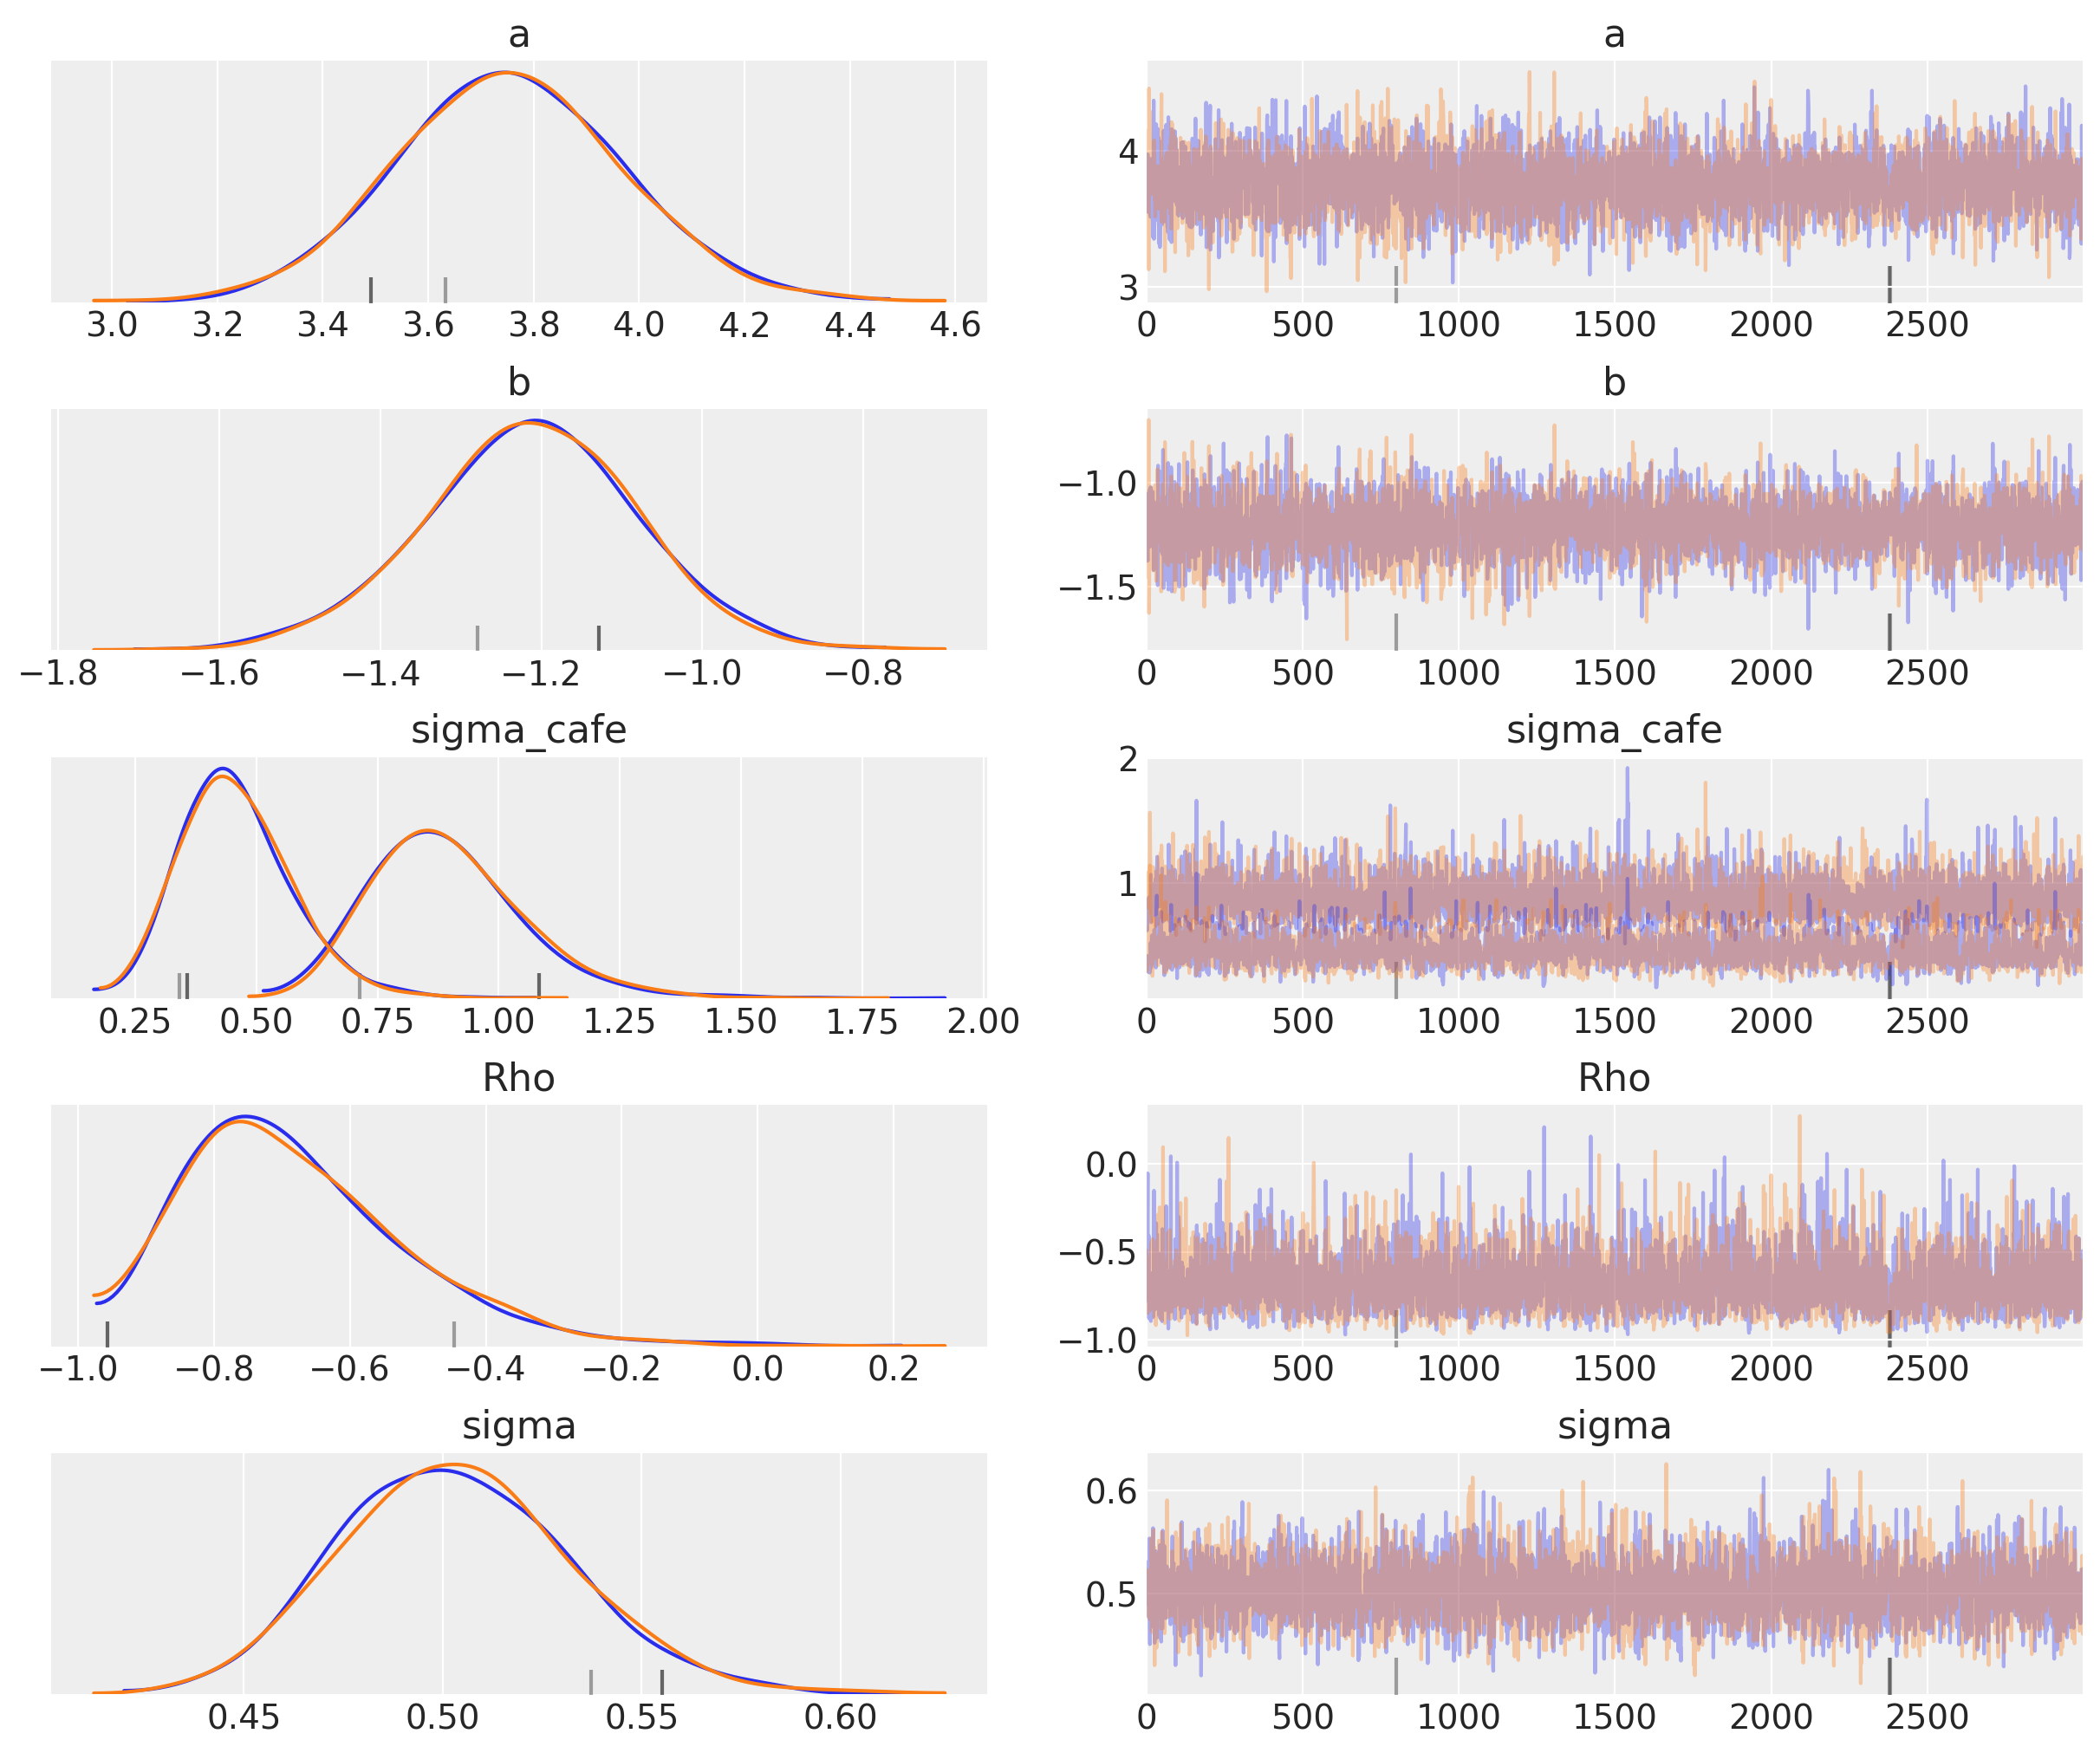

In [34]:
az.plot_trace(trace_m13_m1, 
              var_names=["a", "b", "sigma_cafe", "Rho", "sigma"], 
              compact=True);

Posterior distribution of rho now centred around zero.

# 13M2

In [30]:
a = 3.5        
b = -1.        
sigma_a = 1.   
sigma_b = 0.5  
rho = -0.7

Mu = [a, b]
cov_ab = sigma_a * sigma_b * rho
Sigma = np.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]]) #Sigma covariance matrix

# simulate observations
N_cafes = 20
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

N_visits = 10
afternoon = np.tile([0,1], N_visits * N_cafes//2)
cafe_id = np.repeat(np.arange(N_cafes), N_visits)

mu = a_cafe[cafe_id] + b_cafe[cafe_id]*afternoon
sigma = 0.5 # std dev within cafes
wait = np.random.normal(loc=mu, scale=sigma, size=N_visits*N_cafes)

# Create dataframe
d = pd.DataFrame(dict(cafe=cafe_id , afternoon=afternoon , wait=wait))

cafe  afternoon      wait
0      0          0  2.780634
1      0          1  1.489178
2      0          0  3.880333
3      0          1  2.288062
4      0          0  3.976071
5      0          1  2.606087
6      0          0  3.575515
7      0          1  2.636554
8      0          0  3.964479
9      0          1  2.344413
10     1          0  4.286205

In [36]:
with pm.Model() as m13_m2:
    # Priors for grand mean
    a = pm.Normal('a', mu=0, sd=10)
    b = pm.Normal('b', mu=0, sd=10)
    sd_a = pm.HalfCauchy('sd_a',  beta=1)
    sd_b = pm.HalfCauchy('sd_b',  beta=1)
    
    # Adaptive priors
    a_cafe = pm.Normal('a_cafe', mu=a, sd = sd_a, shape = (N_cafes))
    b_cafe = pm.Normal('b_cafe', mu=b, sd = sd_b, shape = (N_cafes))
    
    mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
    sd = pm.HalfCauchy('sigma', beta=1)
    
    # To fit the model to new data in next exercise (#teasing...)
    wait_data = pm.Data("wait_data", d.wait)
    w = pm.Normal("w", mu, sd, observed=wait_data)

    trace_m13_m2 = pm.sample(3000, tune=3000, cores=2, random_seed=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_cafe, a_cafe, sd_b, sd_a, b, a]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:19<00:00, 619.22draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [37]:
with m13_m1:
    pm.set_data({"wait_data": d.wait})
    trace_m13_m1 = pm.sample(3000, tune=3000, cores=2, random_seed=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ab_cafe, b, a, chol_cov]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:48<00:00, 248.71draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [39]:
# Without covariance matrix
az.summary(trace_m13_m2, var_names=["a", "b", "sd_a", "sd_b"], credible_interval=0.89, round_to=2)

mean    sd  hpd_5.5%  hpd_94.5%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
a     3.75  0.20      3.43       4.06        0.0      0.0   7812.92  7758.25   
b    -1.21  0.12     -1.39      -1.01        0.0      0.0   6273.06  6246.89   
sd_a  0.84  0.16      0.61       1.08        0.0      0.0   5642.07  5348.34   
sd_b  0.41  0.12      0.23       0.60        0.0      0.0   2438.76  2438.76   

      ess_bulk  ess_tail  r_hat  
a      7862.52   4525.52    1.0  
b      6252.97   4439.94    1.0  
sd_a   5878.26   4346.60    1.0  
sd_b   2272.11   2076.78    1.0

In [41]:
# Without covariance matrix
az.summary(trace_m13_m1, var_names=["a", "b", "sigma_cafe"], credible_interval=0.89, round_to=2)

mean    sd  hpd_5.5%  hpd_94.5%  mcse_mean  mcse_sd  ess_mean  \
a              3.76  0.22      3.43       4.11        0.0      0.0   6200.57   
b             -1.21  0.13     -1.42      -1.00        0.0      0.0   5722.61   
sigma_cafe[0]  0.89  0.15      0.66       1.12        0.0      0.0   5551.13   
sigma_cafe[1]  0.46  0.11      0.27       0.62        0.0      0.0   2842.65   

                ess_sd  ess_bulk  ess_tail  r_hat  
a              6130.78   6257.36   3552.45    1.0  
b              5590.59   5740.89   3824.44    1.0  
sigma_cafe[0]  5176.28   5887.05   4411.54    1.0  
sigma_cafe[1]  2842.65   2678.16   3197.80    1.0

In [42]:
az.compare({'no_cov' : trace_m13_m2,
            'with_cov' : trace_m13_m1})

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


rank     waic   p_waic   d_waic    weight       se      dse warning  \
with_cov    0  325.875  30.1043        0  0.847191  17.0657        0    True   
no_cov      1  330.967  30.3027  5.09156  0.152809   17.747  3.77561    True   

         waic_scale  
with_cov   deviance  
no_cov     deviance

## 13M3

In [41]:
# From code chunk 13.17
d_ad = pd.read_csv('/Users/benjaminwee/Documents/courses/resources/Rethinking/Data/UCBadmit.csv', 
                    sep=';')
d_ad['male'] = (d_ad['applicant.gender'] == 'male').astype(int)
d_ad['dept_id'] = pd.Categorical(d_ad['dept']).codes

Dept_id = d_ad['dept_id'].values
Ndept = len(d_ad['dept_id'].unique())

In [42]:
with pm.Model() as m13_m3:
    # First start with specifying priors and structure of co-variance matrix
    # Paramertising with cholesky cov matrix
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # Compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.math.dot(chol, chol.T)
    
    # Use deterministic functions to generate quantities for the std and corr parameters
    sigma_ab = pm.Deterministic('sigma_dept', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    # Priors for grand mean
    a = pm.Normal('a', 0., 10.)
    bm = pm.Normal('bm', 0., 1.)
    mu = pm.MvNormal('ab_dept', mu=tt.stack([a, bm]), chol=chol, shape=(Ndept, 2))
    
    a_dept = pm.Deterministic('a_dept', mu[:, 0])
    bm_dept = pm.Deterministic('bm_dept', mu[:, 1])
    
    p = pm.math.invlogit(mu[Dept_id, 0] + mu[Dept_id, 1] * d_ad['male'])
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_m13_m3 = pm.sample(3000, tune=3000, cores=2, random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ab_dept, bm, a, chol_cov]
Sampling 2 chains: 100%|██████████| 12000/12000 [01:01<00:00, 195.22draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


In [43]:
with pm.Model() as m13_m3_nc:
    # First start with specifying priors and structure of co-variance matrix
    # Paramertising with cholesky cov matrix
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # Compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.math.dot(chol, chol.T)
    
    # Use deterministic functions to generate quantities for the std and corr parameters
    sigma_ab = pm.Deterministic('sigma_dept', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    # Priors for grand mean
    a = pm.Normal('a', 0., 10.)
    bm = pm.Normal('bm', 0., 1.)
    
    # Change means to zero for NC
    mu = pm.MvNormal('ab_dept', mu=tt.stack([0, 0]), chol=chol, shape=(Ndept, 2))
    
    a_dept = pm.Deterministic('a_dept', mu[:, 0])
    bm_dept = pm.Deterministic('bm_dept', mu[:, 1])
    
    # Put grand means into the linear model
    p = pm.math.invlogit(a + mu[Dept_id, 0] + (bm + mu[Dept_id, 1]) * d_ad['male'])
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_m13_m3_nc = pm.sample(3000, tune=3000, cores=2, random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ab_dept, bm, a, chol_cov]
Sampling 2 chains: 100%|██████████| 12000/12000 [03:08<00:00, 63.66draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [8]:
az.summary(trace_m13_m3, 
                     credible_interval=0.89, 
                     round_to=2,
                     var_names=["a", "bm", "a_dept", "bm_dept", "sigma_dept", "Rho"])

mean    sd  hpd_5.5%  hpd_94.5%  mcse_mean  mcse_sd  ess_mean  \
a             -0.50  0.72     -1.62       0.56       0.01     0.01   3901.20   
bm            -0.17  0.24     -0.54       0.19       0.00     0.00   3925.06   
a_dept[0]      1.31  0.25      0.90       1.70       0.00     0.00   2560.50   
a_dept[1]      0.74  0.34      0.17       1.24       0.01     0.00   3675.88   
a_dept[2]     -0.65  0.09     -0.78      -0.50       0.00     0.00   5802.79   
a_dept[3]     -0.62  0.11     -0.78      -0.44       0.00     0.00   4619.00   
a_dept[4]     -1.13  0.12     -1.31      -0.95       0.00     0.00   5770.95   
a_dept[5]     -2.60  0.20     -2.92      -2.28       0.00     0.00   5384.27   
bm_dept[0]    -0.79  0.27     -1.21      -0.35       0.01     0.00   2472.06   
bm_dept[1]    -0.21  0.34     -0.76       0.30       0.01     0.00   3617.95   
bm_dept[2]     0.08  0.14     -0.14       0.30       0.00     0.00   4820.33   
bm_dept[3]    -0.09  0.14     -0.32       0.13       0.00     0.00   4740.11   
bm_dept[4]     0.12  0.19     -0.18       0.42       0.00     0.00   5166.35   
bm_dept[5]    -0.12  0.27     -0.53       0.32       0.00     0.00   4952.29   
sigma_dept[0]  1.68  0.63      0.83       2.44       0.01     0.01   3850.80   
sigma_dept[1]  0.50  0.25      0.16       0.82       0.01     0.00   2205.32   
Rho[0]        -0.32  0.35     -0.89       0.17       0.01     0.00   4663.27   

                ess_sd  ess_bulk  ess_tail  r_hat  
a              3392.04   4191.39   3140.86    1.0  
bm             2977.54   4013.36   3673.98    1.0  
a_dept[0]      2560.50   2524.50   2183.10    1.0  
a_dept[1]      3459.78   3683.86   3807.73    1.0  
a_dept[2]      5802.79   5847.14   4097.49    1.0  
a_dept[3]      4575.34   4624.47   4499.55    1.0  
a_dept[4]      5681.67   5787.27   4280.64    1.0  
a_dept[5]      5381.50   5379.99   4403.80    1.0  
bm_dept[0]     2472.06   2437.70   1898.34    1.0  
bm_dept[1]     3040.85   3627.11   3810.38    1.0  
bm_dept[2]     4789.65   4808.44   4764.82    1.0  
bm_dept[3]     3849.68   4747.51   4296.34    1.0  
bm_dept[4]     4105.10   5180.17   4554.15    1.0  
bm_dept[5]     3501.79   4954.67   4271.32    1.0  
sigma_dept[0]  3748.58   4985.91   3419.25    1.0  
sigma_dept[1]  2205.32   1949.24   1987.12    1.0  
Rho[0]         4640.67   4736.06   4337.96    1.0

In [7]:
centred = az.summary(trace_m13_m3, 
                     credible_interval=0.89, 
                     round_to=2,
                     var_names=["a", "bm", "a_dept", "bm_dept", "sigma_dept", "Rho"])["ess_mean"]

non_centered = az.summary(trace_m13_m3_nc, 
                          credible_interval=0.89, 
                          round_to=2,
                          var_names=["a", "bm", "a_dept", "bm_dept", "sigma_dept", "Rho"])["ess_mean"]

comp = pd.concat([centred, non_centered], axis=1)
comp.columns = ["ess_mean_c", "ess_mean_nc"]
comp["diff"] = comp.ess_mean_c - comp.ess_mean_nc
comp.round()

ess_mean_c  ess_mean_nc    diff
a                  3901.0       1331.0  2570.0
bm                 3925.0       1856.0  2069.0
a_dept[0]          2560.0       1375.0  1186.0
a_dept[1]          3676.0       1484.0  2192.0
a_dept[2]          5803.0       1353.0  4449.0
a_dept[3]          4619.0       1352.0  3267.0
a_dept[4]          5771.0       1372.0  4399.0
a_dept[5]          5384.0       1409.0  3975.0
bm_dept[0]         2472.0       2270.0   202.0
bm_dept[1]         3618.0       2933.0   685.0
bm_dept[2]         4820.0       2053.0  2767.0
bm_dept[3]         4740.0       2296.0  2444.0
bm_dept[4]         5166.0       2339.0  2827.0
bm_dept[5]         4952.0       2766.0  2186.0
sigma_dept[0]      3851.0       2600.0  1251.0
sigma_dept[1]      2205.0       1678.0   528.0
Rho[0]             4663.0       3954.0   709.0

Centred model has higher effective sample sizes. From pymc3 devs notebook:

```
But the non-centered parameterization tends to be better when the variation across clusters is either very small — close to zero — or poorly identified by the data.
```

## 13H1

In [11]:
df = pd.read_csv('/Users/benjaminwee/Documents/courses/resources/Rethinking/Data/bangladesh.csv', sep=";")

df['district_id'] = pd.factorize(df['district'], sort=True)[0]
district_id = df['district_id'].values
n_district = len(df['district_id'].unique())

with pm.Model() as m_12_h1_pp:
    alpha = pm.Normal('alpha', 0, 10)
    sigma = pm.HalfCauchy('sigma', 1)
    a_district = pm.Normal('a_district', 0, sigma, shape = n_district)
    
    p = pm.math.invlogit(alpha + a_district[district_id])
    use_contraception = pm.Binomial('use_contraception', n =1 , p=p, observed=df['use.contraception'])
    trace_12_h1_pp = pm.sample(2000, tune=2000)
    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_district, sigma, alpha]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:15<00:00, 1026.73draws/s]


In [17]:
with pm.Model() as m_m13_1:
    sd_dist = pm.Exponential.dist(1)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.math.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_district', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    a = pm.Normal('a', 0, 10)
    bu = pm.Normal('bu', 0, 1)
    mu = pm.MvNormal('ab_district', mu=tt.stack([a, bu]), chol=chol, shape=(n_district, 2))
    
    a_district = pm.Deterministic('a_district', mu[:, 0])
    bu_district = pm.Deterministic('bu_district', mu[:, 1])
    
    p = pm.math.invlogit(mu[district_id, 0] + mu[district_id, 1]*df["urban"])
    
    used = pm.Bernoulli('used', p=p, observed=df["use.contraception"])
    
    trace_m13_1 = pm.sample(2000, tune=4000, cores=2, random_seed=42, nuts_kwargs={"target_accept": 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ab_district, bu, a, chol_cov]
Sampling 2 chains: 100%|██████████| 12000/12000 [03:20<00:00, 59.97draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [18]:
az.summary(trace_m13_1, var_names=["a", "bu", "sigma_district", "Rho"], credible_interval=0.89, round_to=2)

mean    sd  hpd_5.5%  hpd_94.5%  mcse_mean  mcse_sd  \
a                 -0.71  0.10     -0.88      -0.56       0.00     0.00   
bu                 0.70  0.17      0.42       0.96       0.00     0.00   
sigma_district[0]  0.58  0.10      0.42       0.73       0.00     0.00   
sigma_district[1]  0.79  0.20      0.47       1.09       0.01     0.01   
Rho[0]            -0.66  0.17     -0.89      -0.41       0.01     0.00   

                   ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
a                   3751.51  3692.60   3750.73   3086.40    1.0  
bu                  2599.77  2569.69   2602.03   2882.09    1.0  
sigma_district[0]   1324.55  1324.55   1281.14   1992.62    1.0  
sigma_district[1]    529.67   529.67    513.36    733.20    1.0  
Rho[0]              1084.97  1011.34    993.65   1882.86    1.0

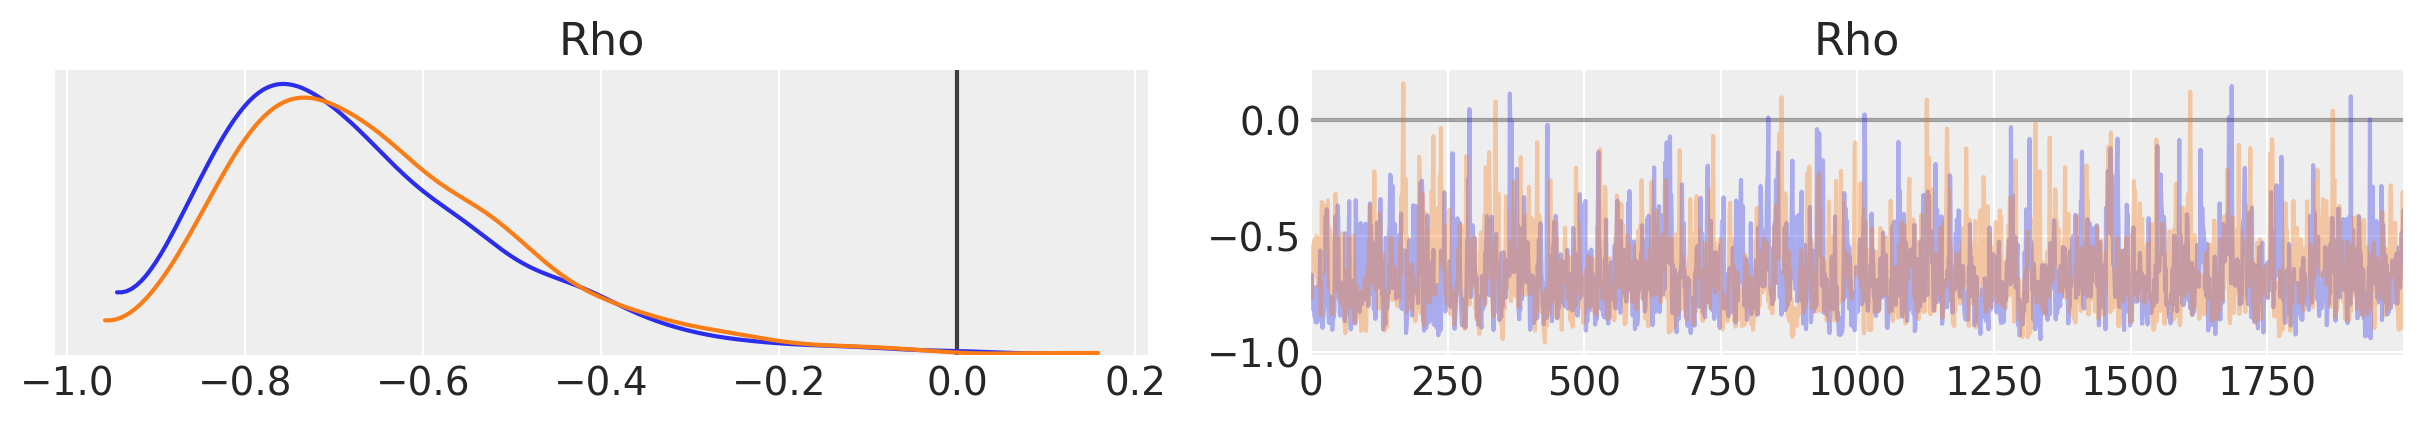

In [20]:
az.plot_trace(trace_m13_1, var_names=["Rho"], lines=[("Rho", {}, 0.)], compact=True);

## 13H2 & 3

In [22]:
d = pd.read_csv("/Users/benjaminwee/Documents/courses/resources/Rethinking/Data/oxboys.csv", sep=";")
d["Subject"] = d.Subject - 1 # 0-indexing
subject_id = d.Subject.values
Nsubjects = len(d.Subject.unique())
d.head()

Subject     age  height  Occasion
0        0 -1.0000   140.5         1
1        0 -0.7479   143.4         2
2        0 -0.4630   144.8         3
3        0 -0.1643   147.1         4
4        0 -0.0027   147.7         5

In [25]:
with pm.Model() as m_m13_23:
    sd_dist = pm.HalfCauchy.dist(beta=1)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.math.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_subject', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    a = pm.Normal('a', d["height"].mean(), 50.)
    bA = pm.Normal('bA', 0., 30.)
    ab_subject = pm.MvNormal('ab_subject', mu=tt.stack([a, bA]), chol=chol, shape=(Nsubjects, 2))
    
    a_subject = pm.Deterministic('a_subject', ab_subject[:, 0])
    bA_subject = pm.Deterministic('bA_subject', ab_subject[:, 1])
    
    mu = a_subject[subject_id] + bA_subject[subject_id]*d["age"]
    sigma = pm.HalfCauchy("sigma", 1.)
    
    prior_checks = pm.sample_prior_predictive(random_seed=42)
    
    h = pm.Normal('h', mu=mu, sigma=sigma, observed=d["height"])
    
    trace_m13_23 = pm.sample(2000, tune=2000, cores=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ab_subject, bA, a, chol_cov]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:22<00:00, 361.11draws/s]


In [27]:
az.summary(trace_m13_23, var_names=["a", "bA", "sigma_subject", 'Rho'], credible_interval=0.89, round_to=2)

mean    sd  hpd_5.5%  hpd_94.5%  mcse_mean  mcse_sd  \
a                 149.39  1.58    146.86     151.84       0.02     0.02   
bA                  6.53  0.34      5.97       7.03       0.01     0.00   
sigma_subject[0]    8.02  1.15      6.22       9.72       0.01     0.01   
sigma_subject[1]    1.68  0.25      1.30       2.07       0.00     0.00   
Rho[0]              0.55  0.13      0.35       0.75       0.00     0.00   

                  ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
a                  4551.98  4548.32   4543.54   3050.36    1.0  
bA                 4047.73  4025.76   4113.17   2879.35    1.0  
sigma_subject[0]   5991.29  5326.35   6651.88   3080.89    1.0  
sigma_subject[1]   4086.89  3793.58   4378.68   2929.12    1.0  
Rho[0]             4448.22  4448.22   4665.15   2630.42    1.0

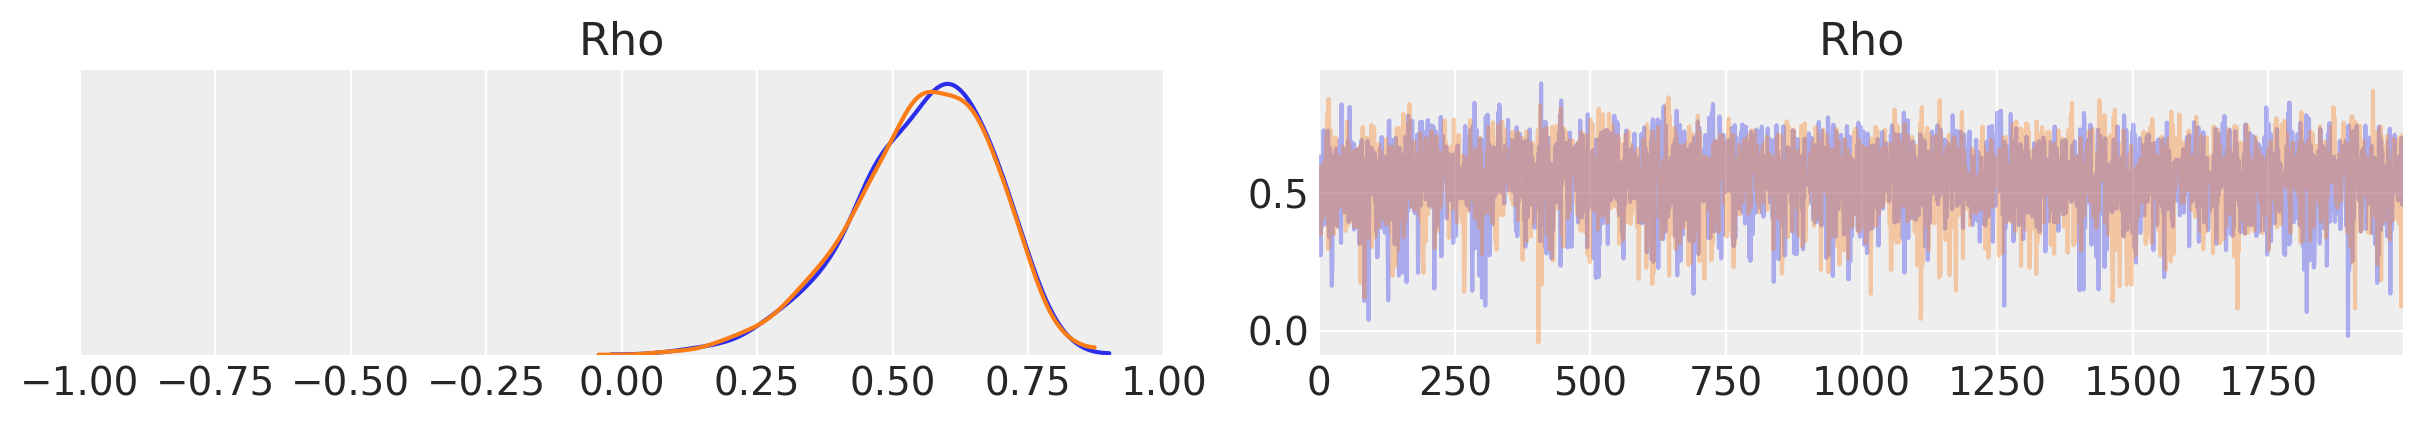

In [28]:
axes = az.plot_trace(trace_m13_23, var_names=["Rho"], compact=True)
axes[0, 0].set_xlim([-1, 1]);

Positive correlation between intercept and slope. Taller -> faster growth (slope)

## 13H4

In [30]:
# From pymc3 devs notebooks, running simulation a few times here
# Get all the mean parameters from the model

post_oxboys = pm.trace_to_dataframe(trace_m13_23)

a_avg = post_oxboys["a"].mean() # average height
bA_avg = post_oxboys["bA"].mean() # average change in height for a unit change in age
Mu = [a_avg, bA_avg]

sigma_a = post_oxboys["sigma_subject__0"].mean() # std dev in intercepts
sigma_b = post_oxboys["sigma_subject__1"].mean() # std dev in slopes
rho = post_oxboys["Rho__0"].mean() # correlation between intercepts and slopes
cov_ab = sigma_a * sigma_b * rho
Sigma = np.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]]) # covariance matrix
Sigma

array([[64.30383911,  7.36999493],
       [ 7.36999493,  2.80571293]])

In [31]:
# Simulate parameters based on posterior means (random heights/slopes based on model predictions)
N_boys = 10
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_boys)
a_ind = vary_effects[:, 0]
bA_ind = vary_effects[:, 1]
vary_effects

array([[159.36338809,   7.78380875],
       [138.53823844,   6.42061217],
       [143.23147205,   4.46128851],
       [146.48066619,   6.17761925],
       [147.46982095,   4.8296876 ],
       [153.93399621,   8.63636942],
       [147.24791665,   7.86371827],
       [157.6788401 ,   7.90717992],
       [167.91465047,  10.10261135],
       [154.9060841 ,   7.55118146]])

In [32]:
# Create dummy data (age sequences for each new oxboy) and run it through 
# the simulated parameters.
N_measures = 9 # nbr observations per boy
age_seq = np.tile(np.linspace(-1, 1, N_measures), N_boys) # each boy observed at 9 different ages
ind_id = np.repeat(np.arange(N_boys), N_measures)

mu_ind = a_ind[ind_id] + bA_ind[ind_id]*age_seq # mean height for each boy, at different ages
sigma_avg = post_oxboys["sigma"].mean() # std dev within boys
heights = np.random.normal(loc=mu_ind, scale=sigma_avg, size=N_boys*N_measures)

post_pred = pd.DataFrame(dict(ind=ind_id, age=age_seq, height=heights))
post_pred.head()

ind   age      height
0    0 -1.00  152.070347
1    0 -0.75  153.644380
2    0 -0.50  154.460129
3    0 -0.25  156.860648
4    0  0.00  159.497685

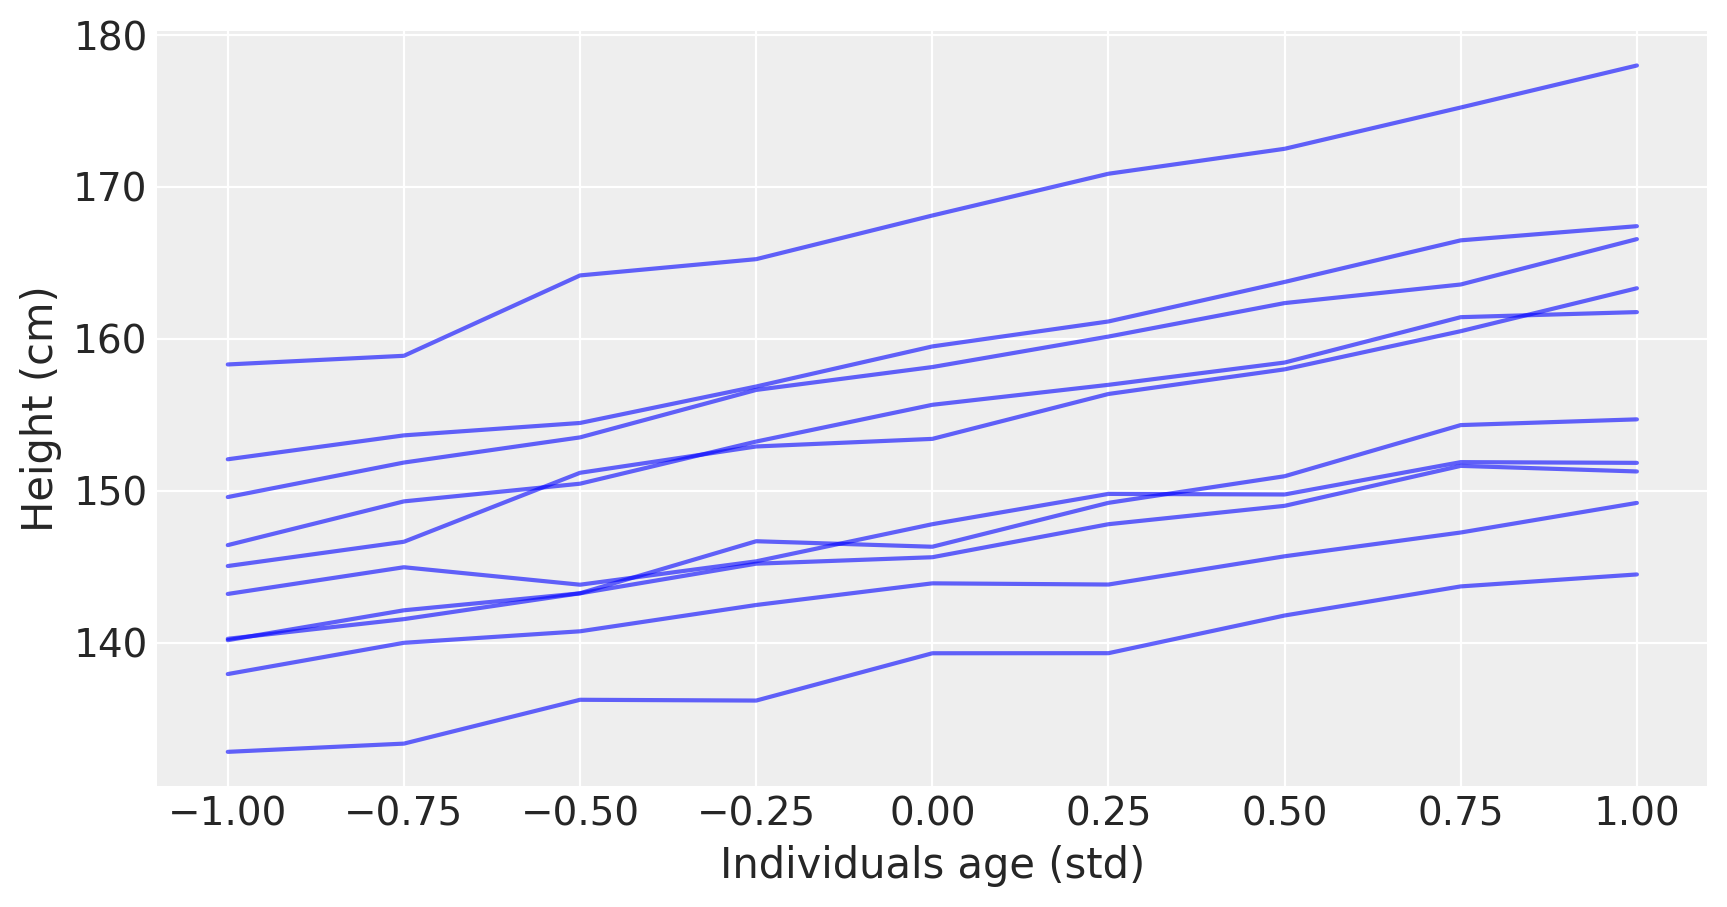

In [34]:
plt.figure(figsize=(10,5))

for i in range(N_boys):
    plt.plot(post_pred.loc[post_pred.ind == i, "age"], post_pred.loc[post_pred.ind == i, "height"], color='b', alpha=.6)

plt.xlabel("Individuals age (std)")
plt.ylabel("Height (cm)");